In [1]:
%%HTML
<script src="require.js"></script>

In [32]:

# Import necessary modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator, RankingEvaluator
from pyspark.sql import functions as F
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Window


<img src='https://i.imgur.com/jzRQsuC.png' width = 600>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Abstract</h1>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Background</h1>
</div>

<div style="background-color: #fff3e4; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h2 style="color: #5a3731; margin: 0;">Problem Statement</h2>
</div>

The study aims to answer the main problem: **How can explicit user ratings be utilized to recommend board games based on similar users?**

To address the main question, the study will also uncover answers to the following subquestion:
- Which collaborative filtering methods, neighborhood- or model-based method, result in a better performance?


<div style="background-color: #fff3e4; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h2 style="color: #5a3731; margin: 0;">Motivation</h2>
</div>

<div style="background-color: #fff3e4; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h2 style="color: #5a3731; margin: 0;">Key Terms</h2>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Methodology</h1>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Data Collection</h1>
</div>

In [24]:
orginal_df = pd.read_csv("/mnt/data/public/bgg/bgg-19m-reviews.csv")
print(f"Shape: {orginal_df.shape}")
print(f"Column Names: {orginal_df.columns}")


Shape: (18964807, 6)
Column Names: Index(['Unnamed: 0', 'user', 'rating', 'comment', 'ID', 'name'], dtype='object')


<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Data Pre-Processing and Cleaning</h1>
</div>

In [29]:
print("Datatype per column:")
print(orginal_df.dtypes)
print()
print("Unique values per column:")
print(orginal_df.nunique())

Datatype per column:
Unnamed: 0      int64
user           object
rating        float64
comment        object
ID              int64
name           object
dtype: object

Unique values per column:
Unnamed: 0    18964807
user            412815
rating           10759
comment        3046149
ID               21839
name             21440
dtype: int64


In [18]:
duplicates = orginal_df[orginal_df.duplicated(subset=["user", "name"], keep=False)]
duplicates = duplicates.sort_values(by="user")
sample_ids = duplicates["ID"].iloc[-2:].to_list()
sample = pd.read_csv("/mnt/data/public/bgg/games_detailed_info.csv")
for id in sample_ids:
    print(sample[sample["id"] == id][['id','primary','alternate']])

        id      primary                                          alternate
17  129622  Love Letter  ['Letters to Santa', 'List Miłosny', 'Lista Sk...
          id      primary                                          alternate
1057  277085  Love Letter  ['List miłosny (Edycja Premium)', 'Love Letter...


/tmp/ipykernel_33203/831687305.py:4: DtypeWarning: Columns (29,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sample = pd.read_csv("/mnt/data/public/bgg/games_detailed_info.csv")


In [21]:
orginal_df = orginal_df[['user', 'rating', 'ID']]

Text(0.5, 1.0, 'Distribution of Board Game Geek Ratings')

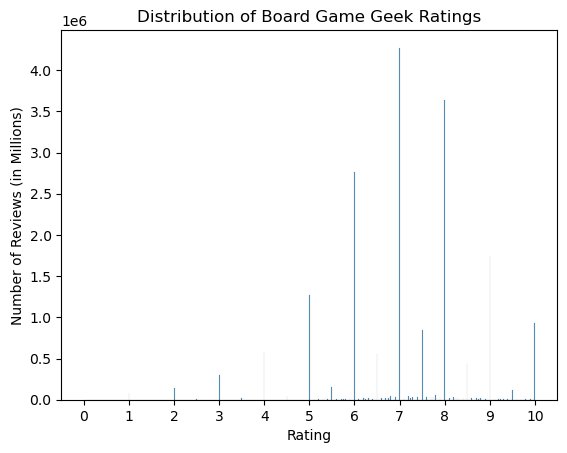

In [33]:
sns.histplot(data=orginal_df, x='rating')
plt.xticks(range(0, 11))
plt.xlabel("Rating")
plt.ylabel("Number of Reviews (in Millions)")
plt.title("Distribution of Board Game Geek Ratings")

In [7]:
duplicates = orginal_df[orginal_df.duplicated(subset=["user", "ID"], keep=False)]

In [8]:
groupby_df = orginal_df.groupby("ID").agg({"rating": "mean", "user": "count"}).sort_values("user", ascending=False)

In [17]:
sns.histplot(data=groupby_df, x='rating')

,rating,user
count,21839.000000,21839.000000
mean,6.415746,868.388708
std,0.929549,3685.057639
min,1.041333,30.000000
25%,5.831637,56.000000
50%,6.446825,122.000000
75%,7.039059,393.000000
max,9.568293,108971.000000


In [9]:
groupby_df['user'].mean()

868.3887082741884

In [10]:
groupby_df['user'].median()

122.0

In [11]:
groupby_df2 = orginal_df.groupby("user").agg({"rating": "mean", "ID": "count"}).sort_values("ID", ascending=False)

In [13]:
groupby_df2

,rating,ID
user,,
oldgoat3769967,6.185752,6471
warta,7.230800,6289
leffe dubbel,5.937541,6068
TomVasel,6.401869,5672
Doel,7.496200,5131
...,...,...
Kingdomlach,9.000000,1
Kingdomwarrior7,10.000000,1
mickotom,8.000000,1


<Axes: ylabel='ID'>

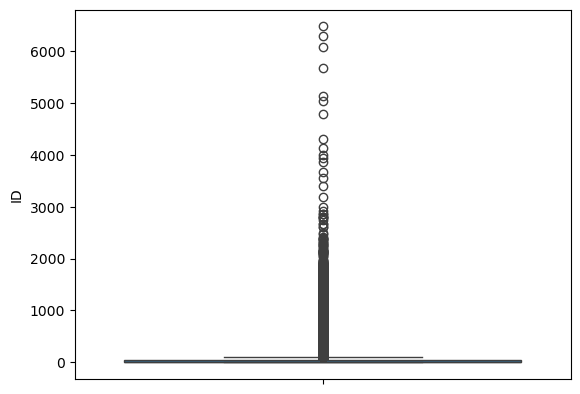

In [15]:
sns.boxplot(groupby_df2['ID'])

In [16]:
groupby_df2.describe()

,rating,ID
count,412815.000000,412815.000000
mean,7.895585,45.940048
std,1.234510,108.486116
min,1.000000,1.000000
25%,7.133333,2.000000
50%,7.785714,12.000000
75%,8.666667,44.000000
max,10.000000,6471.000000


In [12]:
groupby_df2['ID'].mean()

45.94004820561268

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">Exploratory Data Analysis</h1>
</div>

<div style="background-color: #ffd3a0; width: 200px; padding: 10px; border-radius: 5px; width: 98.8%">
    <h1 style="color: #5a3731; margin: 0;">References</h1>
</div>

Van Elteren, J. (2022). *BoardGameGeek Reviews.* https://www.kaggle.com/datasets/jvanelteren/boardgamegeek-reviews/data